# Off-Policy TD(0) and Emphatic TD(0)

I implemented the ETD(0) and TD(0) on the examples from the paper *An Emphatic Approach to the problem of Off-policy Temporal-Difference Learning* (Sutton, R. S., Mahmood A. R., White M.).

This is in the case of the general ETD: the discount parameter is not constant but function of the state and there is an interest function that specify which state are most important (in terms of accurate estimate value).

I also have some slides to present the epmhatic TD(0) algorithm from the paper.

In [1]:
import numpy as np
from scipy.stats import rv_discrete
from matplotlib import pyplot as plt
import string

/Users/Greta/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


I define 3 main classes :
* **updateAlgo** contains all the updating functions for the algorithm. It takes as input the environment (states, step-size parameter, ..) 
* **thetaProblem** defines the environment of the problem: two of its input are the number of states in the problem and whether or not there is a terminal state (such as the second example of $\theta -> 2 \theta$ problem in the paper).
* **policies** contains the different policies appearing in the different examples. 

In [252]:
class updateAlgo : 
    
    def __init__(self,env_pb) : 
        self.env_pb = env_pb
        self.alpha =  self.env_pb.alpha
        
        
    def getUpdates(self,s,F_before,rho_before,rho,e_before) : 
        # function that update the eligibility trace and followon distribution for the ETD algorithm
        i = self.env_pb.getRelativeInterest(s)
        gamma = self.env_pb.getDiscount(s)    
        F = i + gamma * rho_before * F_before
        
        lambda_ = self.env_pb.getLambda(s)
        M = lambda_ * i + (1-lambda_) * F
        
        featureVector = self.env_pb.getFeatureVector(s)
        e = rho * (lambda_ * e_before + M * featureVector)
        
        return e,F
    
    def getUpdateTheta(self,s,new_s,r,theta,e) :
        # function that update theta for the ETD algo
        theta_o = np.copy(theta)
        
        discount = self.env_pb.getDiscount(new_s)
        s_featureVector = self.env_pb.getFeatureVector(s)
        new_s_featureVector = self.env_pb.getFeatureVector(new_s)
        
        theta_update = theta_o + self.alpha * (r + discount * (theta_o.T).dot(new_s_featureVector) 
                               - (theta_o.T).dot(s_featureVector)) * e

        return theta_update
    
    def getUpdateDeterministic(self,theta,A,b,alphabis) :
        try : 
            theta_upd = theta +  alphabis * (b - float(A) *theta)
        except:      
            theta_upd = theta +  alphabis * (b - np.dot(A,theta))
        return theta_upd
    
    def getUpdateOffPolicy(self,s,new_s,theta,rho,r,discountOP) :
        s_featureVector = self.env_pb.getFeatureVector(s)
        new_s_featureVector = self.env_pb.getFeatureVector(new_s)
        
        theta_upd = theta + rho * self.alpha * (r + discountOP * np.dot(theta.T,new_s_featureVector) - np.dot(theta.T,s_featureVector))*s_featureVector
        
        return theta_upd

The definition of the environment ** thetaProblem **takes as input the feature matrix, the discount function and the interest function since those values will be needed when computing the msve. 

In [172]:
class thetaProblem :
    
    def __init__(self,nbStates,terminal,alpha,listDiscounts,interests,featureMatrix,trueValues) : 
        # terminal to indicate whether or not we are in the continuing problem
        self.terminal = terminal
        self.alpha = alpha
        self.states = list(string.lowercase[:nbStates])
        if self.terminal == True : 
            self.states.append('o')
        self.listDiscounts = listDiscounts
        self.interests = interests
        self.featureMatrix = featureMatrix
        self.trueValues = trueValues
        self.nbStates = nbStates
        
    def getNewState(self,s,a) : 
        position_s = self.states.index(s)
        if a == 'left' : 
            try : 
                new_s = self.states[position_s-1]
            except : 
                new_s = s
        if a == 'right' : 
            try : 
                new_s = self.states[position_s+1]
            except : 
                new_s = s
        if a == 'left' and s == self.states[0] : 
            new_s = s

        if a == 'right' and s == self.states[-1] and self.terminal == False : 
            new_s = s
            
        if self.terminal == True and s == self.states[-1] : 
            new_s = self.states[0]

        return new_s
    
    def getDiscount(self,s) : 
        # discount parameter is function of the state
        position_s = self.states.index(s)
        return self.listDiscounts[position_s]
    
    def getLambda(self,s) : 
        # in those examples, lambda = 0 but in general lambda is state dependent
        lambda_ = 0.
        return lambda_
    
    def getRelativeInterest(self,s) :
        position_s = self.states.index(s) 
        return self.interests[position_s]
    
    def getFeatureVector(self,s) : 
        position_s = self.states.index(s) 
        return self.featureMatrix[position_s][:,None]
    
    def getReward(self,s,pb) :
        # reward defined for the two examples (2 states and 5 states).
        if pb == '2' : 
            return 0.
        if pb == '5' : 
            return 1.
        

In [248]:
class policies :
    
    def __init__(self) : 
        self.actions = ['left','right']
        
    def behaviourPolicy(self,terminal) :
        x = [1,2]
        if terminal == True : 
            px = [0.9,0.1]
        if terminal == False : 
            px = [0.5,0.5]
        a = int(rv_discrete(values=(x,px)).rvs(size=1))
        return self.actions[a-1]              

    def targetPolicy(self,s) : 
        x = [1,2]
        px = [0.,1.]
        a = int(rv_discrete(values=(x,px)).rvs(size=1))
        return self.actions[a-1]
    
    def getRho(self,s,a,terminal,behavior,target) : 
        position_a = self.actions.index(a)
        if terminal == True : 
            p_behavior = [0.9,0.1]
        if terminal == False : 
            p_behavior = [0.5,0.5]
        p_target = [0.,1.]
        rho = p_target[position_a] / p_behavior[position_a]
        return rho
    
    def behaviorPolicy5states(self,terminal) : 
        x = [1,2]
        px = [2./3,1./3.]
        a = int(rv_discrete(values=(x,px)).rvs(size=1))
        return self.actions[a-1] 
    
    def getRho5states(self,s,a) : 
        position_a = self.actions.index(a)
        p_behavior = [0.667,0.333]
        p_target = [0.,1.]
        rho = p_target[position_a] / p_behavior[position_a]
        return rho


The function below ** runsEmphatic ** computes all the run for the ETD(0) algorithm on one example that need to be precised. 

In [173]:
def runsEmphatic(envPb,envAlgo,envPolicies,alpha,terminal,maxSteps,maxRuns,theta0,msve,policy,distribution,pb) : 
    runs = dict()
    runs_msve = dict()
    count_run = 0
    while count_run < maxRuns : 

        F = 0.
        e = 0.
        rho_before = 0.
        theta = theta0

        s = envPb.states[np.random.randint(envPb.nbStates)]
        count_step = 0
        thetas = []
        msves = []
        while count_step < maxSteps : 
            # take action, observe reward and new_state
            a = policy(terminal)
            r = envPb.getReward(s,pb)
            new_s = envPb.getNewState(s,a)

            # get rho with the current state and the chosen action
            rho_t = envPolicies.getRho(s,a,terminal)

            # get the updates
            e,F = envAlgo.getUpdates(s,F,rho_before,rho_t,e)

            # update value of parameters
            theta = envAlgo.getUpdateTheta(s,new_s,r,theta,e)
            try :         
                thetas.append(float(theta))
            except:
                pass
            if msve == True : 
                # depending on what we want to study, we compute the value of msve
                msves.append(float(getMSVE(envPb.trueValues,envPb.featureMatrix,theta,distribution,envPb.interests)))

            # memory the previous value of rho
            rho_before = np.copy(rho_t)

            # go to new state and update count of steps
            s = new_s
            count_step += 1

        runs[count_run] = thetas
        runs_msve[count_run] = msves
        count_run += 1
        print 'run ',count_run,' done'
        
    return runs,runs_msve

The function **runsOffPolicy** below computes the runs for the off-policy TD(0) algorithm.

In [242]:
def runsOffPolicy(envPb,envAlgo,envPolicies,alpha,terminal,maxSteps,maxRuns,theta0,msve,policy,distribution,pb,discountOP) : 
    runs = dict()
    count_run = 0
    runs_msve = dict()
    while count_run < maxRuns : 

        theta = theta0
        s = envPb.states[np.random.randint(envPb.nbStates)]
        count_step = 0
        thetas = []
        msves = []
        while count_step < maxSteps : 
            # take action, observe reward and new_state
            a = policy(terminal)
            r = envPb.getReward(s,pb)
            new_s = envPb.getNewState(s,a)

            # get rho with the current state and the chosen action
            if pb == '2' : 
                rho_t = envPolicies.getRho(s,a,terminal)
            if pb == '5' : 
                rho_t = envPolicies.getRho5states(s,a)
            
            # update value of parameters
            theta = envAlgo.getUpdateOffPolicy(s,new_s,theta,rho_t,r,discountOP)
            try :         
                thetas.append(float(theta))
            except:
                pass
            if msve == True : 
                msves.append(float(getMSVE(envPb.trueValues,envPb.featureMatrix,theta,distribution,envPb.interests)))
            
            # go to new state and update count of steps
            s = new_s
            count_step += 1

        runs[count_run] = thetas
        runs_msve[count_run] = msves
        count_run += 1
        
        print 'run ',count_run,' done'
        
    return runs,runs_msve

The function ** deterministicAlgo ** below computes the expected update algorithm and takes as input the **b** and **A** matrix. 

In [159]:
def deterministicAlgo(envPb,envAlgo,envPolicies,A,b,maxSteps,theta0,msve,distribution,alphabis) : 
    count_step = 0
    thetas_determ = []
    msve_determ  =[]
    theta = theta0
    while count_step < maxSteps : 
        # get the updates
        theta = envAlgo.getUpdateDeterministic(theta,A,b,alphabis) 
        try :         
            thetas_determ.append(float(theta))
        except:
            pass
        if msve == True : 
            msve_determ.append(float(getMSVE(envPb.trueValues,envPb.featureMatrix,theta,distribution,envPb.interests)))

        count_step += 1
    
    return thetas_determ,msve_determ

In [160]:
def getMSVE(trueValues,featureMatrix,theta,distribution,interests) : 
    # computes the value of the MSVE weighted by the behavior distribution and the interest function
    measure = 0.
    v = np.dot(featureMatrix,theta)
    for i in range(len(trueValues)) : 
        measure += distribution[i] * interests[i] * (trueValues[i] - v[i])**2
    return measure
    """   
    c = np.array(trueValues) - np.dot(featureMatrix,theta)
    I = np.diag(np.array(interests))
    D = np.diag(np.array(distribution))
    return (c.T).dot(D).dot(I).dot(c)
    """

## $$ \theta \rightarrow 2 \theta \text{ 2 states problem}$$ 

## Results on Non continuing problem

In [165]:
alpha1= 0.001
terminal1 = False # there is no simulated terminal state (to seem as an episodic problem)
maxSteps1 = 5000
maxRuns1 = 50
nbStates1 = 2

discounts1 = [0.,0.9] # discount is function of states
interests1 = [1.,0.] # as well as interests
featureMatrix1 = np.array([[1.],[2.]])
trueValues1 = [0.,0.] # since this is the curve of theta that are of interest, those values do not matter
d_mu1 = [0.5,0.5] # stationary behavior policy
theta01 = 1. # starting theta value
b1 = 0 # b = 0 since there is no reward on any transition in this problem

pol1 = policies()
environment1 = thetaProblem(nbStates1,terminal1,alpha1,discounts1,interests1,featureMatrix1,trueValues1)
upd1 = updateAlgo(environment1)

In [31]:
# computes the runs for the ETD(0) algorithm
runs_ETD = runsEmphatic(environment1,upd1,pol1,alpha1,terminal1,maxSteps1,maxRuns1,theta01,False,pol1.behaviourPolicy,d_mu1,'2')

In [32]:
# computes the runs for the off policy TD(0)
runs_OffPolicy = runsOffPolicy(environment1,upd1,pol1,alpha1,terminal1,maxSteps1,maxRuns1,theta01,False,pol1.behaviourPolicy,d_mu1,'2')

In [166]:
# off policy deterministic
keyMatrix = np.array([[0.5,-0.45],[0.,0.05]])
A1_OP = (featureMatrix1.T).dot(keyMatrix).dot(featureMatrix1)
thetas_determ_OP1,msve_determ_OP1 = deterministicAlgo(environment1,upd1,pol1,A1_OP,b1,maxSteps1,theta01,False,d_mu1,0.001)

In [37]:
theta1,mve1 = runs_ETD
thetaOP_1,mve_OP1 = runs_OffPolicy

In [151]:
# emphatic deterministic
P_pi = np.array([[0.,1.],[0.,1.]])
Gamma = np.array([[0.,0.],[0.,0.9]])
M = np.array([[0.5,0],[0.,0.]])
b = 0
A = (featureMatrix1.T).dot(M).dot(np.identity(2) - Gamma.dot(P_pi)).dot(featureMatrix1)
thetas_determ1,msve_determ1 = deterministicAlgo(environment1,upd1,pol1,A,b,maxSteps1,theta01,False,d_mu1,0.001)

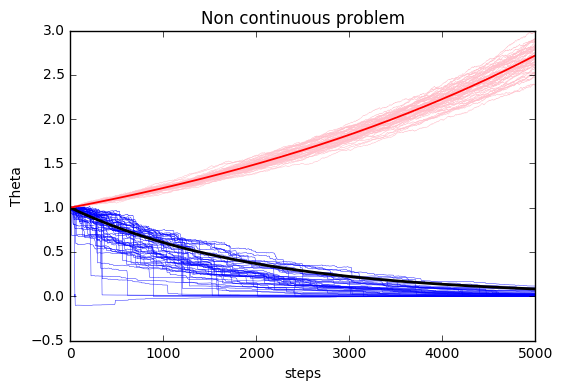

In [169]:
for i in range(maxRuns) : 
    plt.plot(range(maxSteps1),theta1[i],label=i,linewidth=0.3,color='blue')
    plt.plot(range(maxSteps1),thetaOP_1[i],label=i,linewidth=0.3,color='pink')
plt.plot(range(maxSteps),thetas_determ1,label='Deterministic expected update algorithm ETD',color = 'black',linewidth=2.)
plt.plot(range(maxSteps1),thetas_determ_OP1,label='Deterministic expected update algorithm OP',color = 'red',linewidth=1.3)
plt.xlabel('steps')
plt.ylabel('Theta')
plt.title('Non continuous problem')
plt.show()

## Results on continuing problem

In [116]:
alpha2= 0.0001
terminal2 = True # case of continuing problem, simulation of episodic problem
maxSteps2 = 20000
maxRuns2 = 50
nbStates2 = 2

In [117]:
discounts2 = [0.,0.9,0.]
interests2 = [1.,0.,0.]
d_mu2 = [0.5,0.5]
featureMatrix2 = np.array([[1.],[2.],[0]])
theta02 = 1.
trueValues2 = [0.,0.]
b2 = 0. # as earler, no reward considered

pol2 = policies()
environment2 = thetaProblem(nbStates2,terminal2,alpha2,discounts2,interests2,featureMatrix2,trueValues2)
upd2 = updateAlgo(environment2)

In [118]:
# computes the runs of ETD(0)
theta2,mve2 = runsEmphatic(environment2,upd2,pol2,alpha2,terminal2,maxSteps2,maxRuns2,theta02,False,pol2.behaviourPolicy,d_mu2,'2')

In [119]:
# computes the run of off-policy TD(0)
thetaOP_2,mve_OP2 = runsOffPolicy(environment2,upd2,pol2,alpha2,terminal2,maxSteps2,maxRuns2,theta02,False,pol2.behaviourPolicy,d_mu2,'2')

In [125]:
# emphatic deterministic
P_pi2 = np.array([[0.,1.,0.],[0.,0.,1.],[1.,0.,0.]])
Gamma2 = np.array([[0.,0.,0.],[0.,0.9,0.],[0.,0.,0.]])
M2 = np.array([[0.5,0,0.],[0.,0.,0.],[0.,0.,0.]])
A2 = (featureMatrix2.T).dot(M2).dot(np.identity(3) - Gamma2.dot(P_pi2)).dot(featureMatrix2)
thetas_determ2,msve_determ2 = deterministicAlgo(environment2,upd2,pol2,A2,b2,maxSteps2,theta02,False,d_mu2,0.0005)

In [140]:
# deterministic off Policy
keyMatrix2 = (np.diag(np.array([0.9,0.09,0.009]))).dot(np.identity(3) - gamma2 * P_pi2)
gamma2 = 0.9
A2_OP = (featureMatrix2.T).dot(keyMatrix2).dot(featureMatrix2)
thetas_determ_OP2,msve_determ_OP2 = deterministicAlgo(environment2,upd2,pol2,A2_OP,b2,maxSteps2,theta02,False,d_mu2,0.0001)

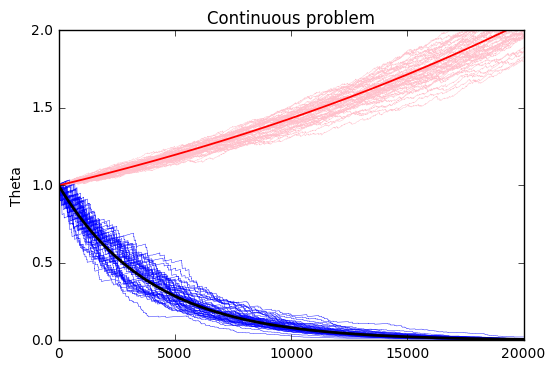

In [142]:
for i in range(maxRuns2) : 
    plt.plot(range(maxSteps2),theta2[i],label=i,linewidth=0.3,color='blue')
    plt.plot(range(maxSteps2),thetaOP_2[i],label=i,linewidth=0.3,color='pink')
plt.plot(range(maxSteps2),thetas_determ2,label='Deterministic expected update algorithm ETD',color = 'black',linewidth=2.)
plt.plot(range(maxSteps2),thetas_determ_OP2,label='Deterministic expected update algorithm OP',color = 'red',linewidth=1.3)
plt.ylabel('Theta')
plt.title('Continuous problem')
plt.ylim((0,2))
plt.show()

## $$ \theta \text{ 5 states problem}$$ 

In [278]:
terminal3 = False
nbStates3 = 5
discounts3 = [0.,1.,1.,1.,0.]
d_mu3 = [0.52,0.26,0.13,0.06,0.03] 
interests3 = [1.,1.,1.,1.,1.]
featureMatrix3 = np.array([[1.,0.,0.],[1.,1.,0.],[0.,1.,0.],[0,1.,1.],[0.,0.,1.]])
theta03 = np.zeros((3,1))
maxSteps3 = 50000
maxRuns3 = 50
alpha3 = 0.001
trueValues3 = [4.,3.,2.,1.,1.]

pol3 = policies()
environment3 = thetaProblem(nbStates3,terminal3,alpha3,discounts3,interests3,featureMatrix3,trueValues3)
upd3 = updateAlgo(environment3)

In [199]:
# runs emphatic
runs3,runs_msve3 = runsEmphatic(environment3,upd3,pol3,alpha3,terminal3,maxSteps3,maxRuns3,theta03,True,pol3.behaviorPolicy5states,d_mu,'5')

In [281]:
# emphatic deterministic
P_pi3 = np.array([[0.,1.,0.,0.,0.],[0.,0.,1.,0.,0.],[0.,0.,0.,1.,0.],[0.,0.,0.,0.,1.],[0.,0.,0.,0.,1.]])
Gamma3 = np.diag((discounts3))
i = np.array(interests3)[:,None]
f = (np.linalg.inv(np.identity(5) - Gamma3.dot(P_pi3.T))).dot(i)
M3 = f * np.identity(5)
b3 = (featureMatrix3.T).dot(M3).dot(np.ones((5,1)))
A3 = (featureMatrix3.T).dot(M3).dot(np.identity(5) - P_pi3.dot(Gamma3)).dot(featureMatrix3)
thetas_determ3,msve_determ3 = deterministicAlgo(environment3,upd3,pol3,A3,b3,maxSteps3,theta03,True,d_mu3,0.001)

In [259]:
# runs off policy
runs_OP3,runs_msve_OP3 = runsOffPolicy(environment3,upd3,pol3,alpha3,terminal3,maxSteps3,maxRuns3,theta03,True,pol3.behaviorPolicy5states,d_mu3,'5',1.)

In [227]:
# deterministic off Policy
b3_OP = (featureMatrix3.T).dot(np.array(d_mu3)[:,None])
gamma3 = 1.
A3_OP = (featureMatrix3.T).dot(np.diag(np.array(d_mu3))).dot(np.identity(5) - gamma3 * P_pi3).dot(featureMatrix3)
thetas_determ_OP3,msve_determ_OP3 = deterministicAlgo(environment3,upd3,pol3,A3_OP,b3_OP,maxSteps3,theta03,True,d_mu3,0.001)

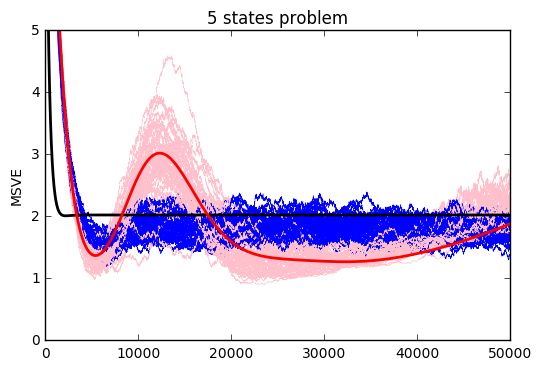

In [282]:
for i in range(maxRuns3) : 
    plt.plot(range(maxSteps3),runs_msve3[i],label=i,linewidth=0.3,color='blue')
    plt.plot(range(maxSteps3),runs_msve_OP3[i],label=i,linewidth=0.3,color='pink')
plt.plot(range(maxSteps3),msve_determ3,label='Deterministic expected update algorithm ETD',color = 'black',linewidth=2.)
plt.plot(range(maxSteps3),msve_determ_OP3,label='Deterministic expected update algorithm OP',color = 'red',linewidth=2.)
plt.ylabel('MSVE')
plt.title('5 states problem')
plt.ylim((0,5))
plt.show()